In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import scipy.misc
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.chdir("/kaggle/input/")
# os.mkdir('/kaggle/input/slim_trained')
for dirname, _, filenames in os.walk('../input/siim-covid19-detectionut'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
data_image = pd.read_csv(r'../input/siim-covid19-detection/train_image_level.csv')
data_study  = pd.read_csv(r'../input/siim-covid19-detection/train_study_level.csv')

In [3]:
for image in data_image:
    print(image)
    print(len(data_image[image].unique().tolist()))
    
print('\n')
print(len(data_study['id'].unique().tolist()))    

id
6334
boxes
4295
label
4295
StudyInstanceUID
6054


6054


data_image['StudyInstanceUID'] and data_study['id'] are the same. -> they are related. <br>
data_image['id'] and data_study['id'] are not the same. -> some data_study are duplicated.

# **Concatinate the above files by ID's**

**Step1: Get the Path for the images**

In [4]:
trainimlist = []

for dirname, _, filenames in os.walk('../input/siim-covid19-detection/train'):
    for filename in filenames:
        trainimlist.append(os.path.join(dirname, filename))

**Step2: check image_id and train/Id's are the same**

In [5]:
# check id in train_imgage_level and Names in the train folder are the same

# to store path with order by id in train_imgage_level

Path = [] 

for image_id in data_image['id']:
    target = image_id.replace('_image', '')
    for path in trainimlist:
        if target in path: 
            Path.append(path)

**Adding the Path list to the data_image file**

In [6]:
data_image["Path"] = pd.Series(Path, index=data_image.index)

# data_image id (6334) and images in train folder (6334) are one-to-one relationships
len(data_image['Path'].unique().tolist())

6334

In [7]:
# checking 
data_image.head(3)

,id,boxes,label,StudyInstanceUID,Path
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,../input/siim-covid19-detection/train/5776db0c...
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,../input/siim-covid19-detection/train/ff0879eb...
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,../input/siim-covid19-detection/train/9d514ce4...


In [8]:
for itr in data_study['id']:
    data_study['id'] = data_study['id'].str.replace('_study', '')

StudyInstanceID and data_study['id'] are related. <br>
So, removing _study from data_study for merge the 2 data-frames.

In [9]:
data_study = data_study.rename(columns={'id': "StudyInstanceUID"})

This step is for merge as merge requires the same column name

In [10]:
train = pd.merge(data_image, data_study, on='StudyInstanceUID')

Only rows are kept for which common keys are found in both data frames. <br>
In case you want to keep all rows from the left data frame (data_image) and only add values from data_study where a matching key is available, you can use how="left".

In [11]:
# saving data_frame: check output /kaggle/working/slim folder 
train.to_csv('/kaggle/working/train_data.csv',index=False)

# Analyzing DataSet

**Importing dataset**

In [12]:
train_data = pd.read_csv('../input/slim-trained/train_data.csv')

**Analyzing proportion of the type of disease**

In [13]:
for itr in train_data[['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance',
       'Atypical Appearance' ]]:
    print(train_data[itr].value_counts())

0    4598
1    1736
Name: Negative for Pneumonia, dtype: int64
0    3327
1    3007
Name: Typical Appearance, dtype: int64
0    5226
1    1108
Name: Indeterminate Appearance, dtype: int64
0    5851
1     483
Name: Atypical Appearance, dtype: int64


<AxesSubplot:xlabel='Atypical Appearance', ylabel='count'>

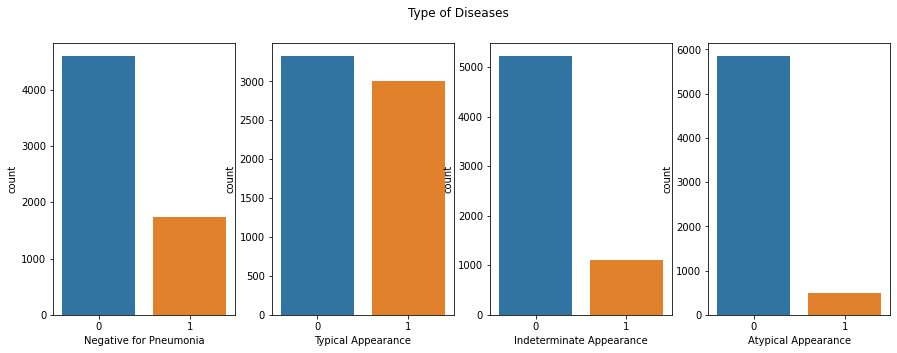

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle('Type of Diseases')
sns.countplot(ax=axes[0], x='Negative for Pneumonia', data=train_data)
sns.countplot(ax=axes[1], x='Typical Appearance', data=train_data)
sns.countplot(ax=axes[2], x='Indeterminate Appearance', data=train_data)
sns.countplot(ax=axes[3], x='Atypical Appearance', data=train_data)

**Separating data by the type of disease**

In [15]:
df = train_data.loc[(train_data['Typical Appearance'] == 1),['id','boxes']] #df will contain only id and boxes info of Typical Appearance

**checking no boundig boxes**

In [16]:
df['boxes'].isnull().sum() # some of boxes info is not given -> must handles the issues for the object detection

153

**Extracting the boxes info**

In [17]:
# boxes are located around lef and right lugs -> 2 boxes (basically)
# Of course, some images have more than 2 boxes or only 1 box, but that's rare cases

first_box = pd.DataFrame(columns = ['id', 'x', 'y', 'width', 'height']) 
second_box = pd.DataFrame(columns = ['id', 'x', 'y', 'width', 'height'])

In [18]:
import re # for replacing pattern of regex

for id, value in zip(df['id'], df['boxes']):  # value will have boxes infor for as one big string                 
    
    if type(value) is not float: # nan -> "" -> 0 becomes float type
        
        s = value.split(",") #split by , and i is list (array)

        row = [id] # this array append to the dataframe as new row
        
        first = 1 # for deciding storing the data

        for itr in s:

            m =  re.sub("\W*[a-z]+\W*:\s", "", itr) #m only contains numerical 
            
            if m[-1] == "}": # some of m have 123.45} due to the given format
                m = m.rstrip(m[-1])
                
            elif m[-1] == "]": # some of m have 123.45}] due to the given format
                m = m.rstrip(m[-2:])

            m = float(m) # convert m as float 

            row.append(m) # row had [id, x, y, width, height] 

            if len(row) == 5: # reset the row for the next row: we assume many images have 2 boxes                
                
                if first == 1: # 
                    index = len(first_box) # geting index number to add                
                    first_box.loc[index] = row # adding the row
                    first += 1
                    
                else: # second or more boxes come here 
                    index = len(second_box) # geting index number to add         
                    second_box.loc[index] = row # adding the row
                    
                row.clear() # delete row values
                row.append(id) # add id as this image has more than 1 box
                
    else: # no bounding box
        row = [id, 0, 0, 0, 0] # store only name
        
        first_index = len(first_box) # diiferent index sizes as we assume multiple boxes
        second_index = len(second_box) # diiferent index sizes as we assume multiple boxes
        
        first_box.loc[first_index], second_box.loc[second_index] = row, row
                   
        row.clear() 

In [19]:
first_box.head(5), second_box.head(5)

(                   id          x           y       width      height
 0  000a312787f2_image  789.28836   582.43035  1026.65662  1917.30292
 1  0012ff7358bc_image  677.42216   197.97662   867.79767   999.78214
 2  001bd15d1891_image  623.23328  1050.00000   714.00000  1106.00000
 3  002e9b2128d0_image  276.72917   627.42968   910.58859  1655.81519
 4  00326161e51e_image  542.96057   364.37257   590.36261   889.78085,
                    id           x          y       width      height
 0  000a312787f2_image  2245.91208  591.20528  1094.66162  1761.54944
 1  0012ff7358bc_image  1792.69064  402.55250   617.02734  1204.35800
 2  001bd15d1891_image  2578.56661  998.66667   662.66667  1120.00000
 3  002e9b2128d0_image  1864.18229  745.22656   875.06262  1535.09888
 4  00326161e51e_image  1743.45854  782.42827   615.78491   771.14337)

In [20]:
dups = second_box.pivot_table(index=['id'], aggfunc='size')
print(dups.max())
print(dups.median(), dups.mean()) # median < mean = right skewed

7
1.0 1.0671140939597314


In [21]:
# check the error: if this values == df['boxes'].isnull().sum(), the extraction is okay. (not x and y as they are just postion can be 0)
(first_box['height'] == 0).sum()

153

In [22]:
first_box.describe() 

,x,y,width,height
count,3007.000000,3007.000000,3007.000000,3007.000000
mean,969.310364,777.661433,717.174914,1097.281153
std,810.873967,482.621665,319.237580,544.337978
min,-3.555580,0.000000,0.000000,0.000000
25%,398.514030,415.010045,518.444610,706.983310
50%,651.035080,727.680000,714.265560,1087.052140
75%,1591.793935,1082.927365,918.456510,1470.599170
max,3701.636970,2842.484690,1768.733950,2865.412870


In [23]:
second_box.describe() 

,x,y,width,height
count,3180.000000,3180.000000,3180.000000,3180.000000
mean,1482.159739,862.698810,684.654029,1018.751443
std,899.416752,516.124094,319.747129,546.697112
min,0.000000,0.000000,0.000000,0.000000
25%,627.029327,488.096250,476.216705,606.813740
50%,1636.906110,800.996975,675.853365,987.223910
75%,2111.494363,1205.717710,888.705575,1394.227353
max,3897.917810,2780.892390,1919.800000,3140.152040


**Replacing no boxing with mean values** <br>
**Not using x and y as they can be 0.**

In [24]:
# filling own mean will change the true mean values, so, need to store the value before fill in itself 

x_mean = first_box['x'].mean()
y_mean = first_box['y'].mean()
width_mean = first_box['width'].mean()
height_mean = first_box['height'].mean() 

first_box['x'] = first_box['x'].mask(first_box['height'] == 0, x_mean)
first_box['y'] = first_box['y'].mask(first_box['height'] == 0, y_mean)
first_box['width'] = first_box['width'].mask(first_box['height'] == 0, width_mean)
first_box['height'] = first_box['height'].mask(first_box['height'] == 0, height_mean)

In [25]:
# filling own mean will change the true mean values, so, need to store the value before fill in itself 

x_mean = second_box['x'].mean()
y_mean = second_box['y'].mean()
width_mean = second_box['width'].mean()
height_mean = second_box['height'].mean() 

second_box['x'] = second_box['x'].mask(second_box['height'] == 0, x_mean)
second_box['y'] = second_box['y'].mask(second_box['height'] == 0, y_mean)
second_box['width'] = second_box['width'].mask(second_box['height'] == 0, width_mean)
second_box['height'] = second_box['height'].mask(second_box['height'] == 0, height_mean)

In [26]:
print((first_box['height'] == 0).sum(), (second_box['height'] == 0).sum()) # assume both are 0 as we filled in with mean of the values

0 0


**Saving file**

In [27]:
first_box.to_csv('/kaggle/working/Typical_Appearance1.csv',index=False)
second_box.to_csv('/kaggle/working/Typical_Appearance2.csv',index=False)

# Convert Image files to jpg

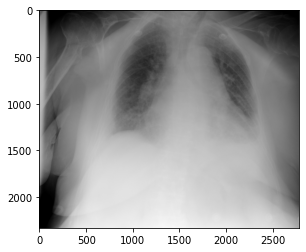

In [28]:
#!pip install pydicom
from pydicom import dcmread
from pydicom.data import get_testdata_file
import scipy.misc
from PIL import Image
import matplotlib.pyplot as plt

iu = '65761e66de9f.dcm' # string type
Input_Image = pydicom.read_file('../input/siim-covid19-detection/train/00086460a852/9e8302230c91/65761e66de9f.dcm') # class type
img = Input_Image.pixel_array
res = (np.maximum(img, 0) / img.max())*255 # Normalize
# res = res.astype(np.uint8) # color for image 
Output_Image = Image.fromarray(res)
plt.imshow(Output_Image)
# Output_Image.save('/kaggle/working//slim/' + iu.replace('.dcm','.png')) # save jpg and png
